In [ ]:
import pandas as pd
import numpy as np
import json
# plotting
import matplotlib.pyplot as plt
# statistical fitting of models
import statsmodels.api as sm
import statsmodels.formula.api as smf
#opening data
import os
import pathlib
import warnings
#used for plots
from scipy import stats
from mplsoccer import PyPizza, FontManager
import ast

pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

from utils.progressive_passes import *
from utils.xg_calculator import *
from utils.goals_assists_passes import *
from utils.final_third_stuff import *
from utils.duels_won import *


In [2]:
df = pd.read_csv('events.csv')
df.head()

,game_id,period,minute,second,expanded_minute,type,outcome_type,team_id,team,player_id,...,goal_mouth_z,blocked_x,blocked_y,qualifiers,is_touch,is_shot,is_goal,card_type,related_event_id,related_player_id
0,1821049.0,FirstHalf,0.0,NaN,0.0,OffsideGiven,Unsuccessful,32.0,Man Utd,300299.0,...,NaN,NaN,NaN,[],False,NaN,NaN,NaN,NaN,NaN
1,1821049.0,FirstHalf,0.0,0.0,0.0,Start,Successful,32.0,Man Utd,NaN,...,NaN,NaN,NaN,[],False,NaN,NaN,NaN,NaN,NaN
2,1821049.0,FirstHalf,0.0,0.0,0.0,Start,Successful,170.0,Fulham,NaN,...,NaN,NaN,NaN,[],False,NaN,NaN,NaN,NaN,NaN
3,1821049.0,FirstHalf,0.0,0.0,0.0,Pass,Successful,170.0,Fulham,243254.0,...,NaN,NaN,NaN,"[{'type': {'displayName': 'Zone', 'value': 56}...",True,NaN,NaN,NaN,NaN,NaN
4,1821049.0,FirstHalf,0.0,1.0,0.0,Pass,Successful,170.0,Fulham,297395.0,...,NaN,NaN,NaN,"[{'type': {'displayName': 'PassEndX', 'value':...",True,NaN,NaN,NaN,NaN,NaN


In [3]:
df.columns

Index(['game_id', 'period', 'minute', 'second', 'expanded_minute', 'type',
       'outcome_type', 'team_id', 'team', 'player_id', 'player', 'x', 'y',
       'end_x', 'end_y', 'goal_mouth_y', 'goal_mouth_z', 'blocked_x',
       'blocked_y', 'qualifiers', 'is_touch', 'is_shot', 'is_goal',
       'card_type', 'related_event_id', 'related_player_id'],
      dtype='object')

In [4]:
import pandas as pd
import ast

df = pd.read_csv('events.csv', low_memory=False)

def cap_minute(row):
    """Cap minute based on period: FirstHalf=45, SecondHalf=90"""
    if row['period'] == 'FirstHalf':
        return min(row['minute'], 45)
    else:
        return min(row['minute'], 90)

# Step 1: Parse FormationSet to get starting XI
formation_sets = df[(df['type'] == 'FormationSet') & (df['period'] == 'PreMatch')].copy()

def extract_starters(qual_str):
    try:
        qualifiers = ast.literal_eval(qual_str)
        players, positions = None, None
        for q in qualifiers:
            if q['type']['displayName'] == 'InvolvedPlayers':
                players = [int(p) for p in q['value'].split(',')]
            elif q['type']['displayName'] == 'TeamPlayerFormation':
                positions = [int(p) for p in q['value'].split(', ')]
        if players and positions:
            return [p for p, pos in zip(players, positions) if pos > 0]
    except:
        pass
    return []

formation_sets['starters'] = formation_sets.apply(lambda r: extract_starters(r['qualifiers']), axis=1)
starters_df = formation_sets[['game_id', 'team', 'starters']].explode('starters')
starters_df = starters_df.rename(columns={'starters': 'player_id'})
starters_df['start_minute'] = 0

# Step 2: Get substitutes with period-aware capping
subs_on = df[df['type'] == 'SubstitutionOn'][['game_id', 'player_id', 'team', 'minute', 'period']].copy()
subs_on['start_minute'] = subs_on.apply(cap_minute, axis=1)
subs_on = subs_on.drop(columns=['minute', 'period'])

all_players = pd.concat([starters_df, subs_on], ignore_index=True)

# Step 3: Get end times with period-aware capping
subs_off = df[df['type'] == 'SubstitutionOff'][['game_id', 'player_id', 'minute', 'period']].copy()
subs_off['end_minute_sub'] = subs_off.apply(cap_minute, axis=1)
subs_off = subs_off.drop(columns=['minute', 'period'])

sent_off = df[df['card_type'].isin(['Red', 'SecondYellow'])][['game_id', 'player_id', 'minute', 'period']].copy()
sent_off['end_minute_card'] = sent_off.apply(cap_minute, axis=1)
sent_off = sent_off.drop(columns=['minute', 'period'])

# Step 4: Match duration is 90
all_players['match_duration'] = 90

# Step 5: Merge end times
player_minutes = all_players.merge(subs_off, on=['game_id', 'player_id'], how='left')
player_minutes = player_minutes.merge(sent_off, on=['game_id', 'player_id'], how='left')

player_minutes['end_minute'] = player_minutes[['end_minute_sub', 'end_minute_card', 'match_duration']].min(axis=1)
player_minutes['minutes_played'] = (player_minutes['end_minute'] - player_minutes['start_minute']).clip(lower=0)

# Step 6: Get player names
player_names = df[df['player_id'].notna()][['player_id', 'player']].drop_duplicates()
player_minutes = player_minutes.merge(player_names, on='player_id', how='left')

# Step 7: Aggregate season totals
season_minutes = player_minutes.groupby(['player_id', 'player', 'team']).agg(
    total_minutes=('minutes_played', 'sum'),
    games_played=('game_id', 'nunique')
).reset_index().sort_values('total_minutes', ascending=False)

player_minutes.to_csv('player_minutes.csv', index=False)

print(season_minutes.head(20))

     player_id             player               team  total_minutes  \
41     92173.0         Bernd Leno             Fulham         3420.0   
77    110189.0    Jordan Pickford            Everton         3420.0   
157   276366.0         David Raya            Arsenal         3420.0   
27     78386.0          Matz Sels  Nottingham Forest         3420.0   
193   304008.0     Dean Henderson     Crystal Palace         3420.0   
341   372724.0     Nathan Collins          Brentford         3420.0   
292   353377.0       Bryan Mbeumo          Brentford         3415.0   
73    108226.0      Mohamed Salah          Liverpool         3374.0   
431   410175.0     Moisés Caicedo            Chelsea         3351.0   
333   368310.0  Maximilian Kilman           West Ham         3348.0   
454   424273.0       Milos Kerkez        Bournemouth         3336.0   
30     82277.0           Dan Burn          Newcastle         3330.0   
212   319785.0  Nikola Milenkovic  Nottingham Forest         3330.0   
50    

In [5]:
final_third = final_third_things(df)
duels = duels_won(df)
gakp = goals_assists_key_passes(df)
npxg = calculate_total_xg(df)
smart_passes = p_p(df)


In [6]:
players = df["player_id"].unique()
summary = pd.DataFrame(players, columns = ["player_id"])
summary = summary.merge(npxg, how = "left", on = ["player_id"]).merge(final_third, how = "left", on = ["player_id"]).merge(duels, how = "left", on = ["player_id"]).merge(smart_passes, how = "left", on = ["player_id"]).merge(gakp, how = "left", on = ["player_id"])

# Drop 'player' column from npxg merge to avoid duplicate with season_minutes
if 'player' in summary.columns:
    summary = summary.drop(columns=['player'])

summary = season_minutes.merge(summary, how = "left", on = ["player_id"])
summary = summary.fillna(0)
summary = summary.loc[summary["total_minutes"] > 400]

In [7]:
stat_cols = ['total_xg', 'final_third_passes', 'final_third_receptions', 
             'air_duels_won', 'ground_duels_won', 'progressive_passes', 
             'goals', 'assists', 'key_passes']

summary_per_90 = pd.DataFrame()
summary_per_90["player"] = summary["player"]
for col in stat_cols:
    if col in summary.columns:
        summary_per_90[col + "_per90"] = summary[col] * 90 / summary["total_minutes"]


In [8]:
#player to investigate - Mohamed Salah
salah = summary_per_90.loc[summary_per_90["player"] == "Mohamed Salah"]
#columns in order for radar
salah = salah[['total_xg_per90', "goals_per90", "assists_per90", "key_passes_per90", "progressive_passes_per90", "final_third_passes_per90", "final_third_receptions_per90", "ground_duels_won_per90", "air_duels_won_per90"]]
per_90_columns = salah.columns[:]
values = [round(salah[column].iloc[0], 2) for column in per_90_columns]
percentiles = [int(stats.percentileofscore(summary_per_90[column], salah[column].iloc[0])) for column in per_90_columns]

Text(0.515, 0.942, 'Premier League | Season 2024-25')

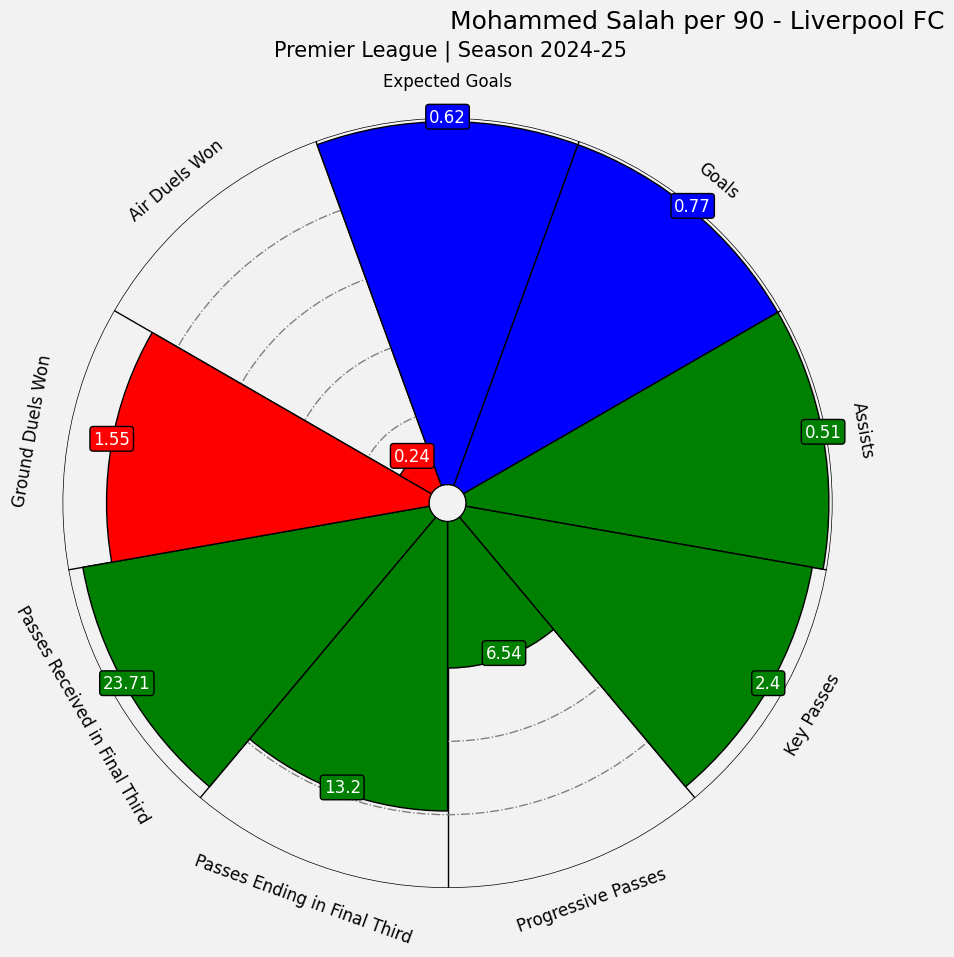

In [9]:
#list of names on plots
names = ["Expected Goals", "Goals", "Assists", "Key Passes", "Progressive Passes", "Passes Ending in Final Third", "Passes Received in Final Third", "Ground Duels Won", "Air Duels Won"]
slice_colors = ["blue"] * 2 + ["green"] * 5 + ["red"] * 2
text_colors = ["white"]*9

#PIZZA PLOT
baker = PyPizza(
    params=names,
    min_range = None,
    max_range = None,               # list of parameters
    straight_line_color="#000000",  # color for straight lines
    straight_line_lw=1,             # linewidth for straight lines
    last_circle_lw=1,               # linewidth of last circle
    other_circle_lw=1,              # linewidth for other circles
    other_circle_ls="-."            # linestyle for other circles
)
#making pizza for our data
fig, ax = baker.make_pizza(
    percentiles,              # list of values
    figsize=(10, 10),      # adjust figsize according to your need
    param_location=110,
    slice_colors=slice_colors,
    value_colors = text_colors,
    value_bck_colors=slice_colors, # where the parameters will be added
    kwargs_slices=dict(
        facecolor="cornflowerblue", edgecolor="#000000",
        zorder=2, linewidth=1
    ),                   # values to be used when plotting slices
    kwargs_params=dict(
        color="#000000", fontsize=12, va="center"
    ),                   # values to be used when adding parameter
    kwargs_values=dict(
        color="#000000", fontsize=12,
        bbox=dict(
            edgecolor="#000000", facecolor="cornflowerblue",
            boxstyle="round,pad=0.2", lw=1
        )
    )                    # values to be used when adding parameter-values
)

#putting text
texts = baker.get_value_texts()
for i, text in enumerate(texts):
    text.set_text(str(values[i]))
# add title
fig.text(
    0.515, 0.97, "Mohammed Salah per 90 - Liverpool FC", size=18
)

# add subtitle
fig.text(
    0.515, 0.942,
    "Premier League | Season 2024-25",
    size=15,
    ha="center", color="#000000"
)

In [10]:
possession_dict = {}

for i, row in player_minutes.iterrows():
    player_id = row["player_id"]
    team_name = row["team"]
    game_id = row["game_id"]
    
    if str(player_id) not in possession_dict.keys():
        possession_dict[str(player_id)] = {'team_passes': 0, 'all_passes': 0}
    
    min_in = row["start_minute"]
    min_out = row["end_minute"]
    
    match_df = df.loc[df["game_id"] == game_id].copy()
    # Convert period + minute to continuous minute (add 45 for SecondHalf)
    match_df["cont_minute"] = match_df.apply(
        lambda x: x["minute"] + 45 if x["period"] == "SecondHalf" else x["minute"], axis=1
    )
    
    player_in_match_df = match_df.loc[(match_df["cont_minute"] >= min_in) & (match_df["cont_minute"] <= min_out)]
    
    # Take passes and aerial duels
    all_passes = player_in_match_df.loc[player_in_match_df["type"].isin(["Pass", "Aerial"])]
    
    # Filter out unsuccessful aerials (keep only successful=True)
    if len(all_passes) > 0:
        unsuccessful_aerials = all_passes.loc[(all_passes["type"] == "Aerial") & (all_passes["outcome_type"] != "Successful")]
        all_passes = all_passes.drop(unsuccessful_aerials.index)
    
    team_passes = all_passes.loc[all_passes["team"] == team_name]
    
    possession_dict[str(player_id)]["team_passes"] += len(team_passes)
    possession_dict[str(player_id)]["all_passes"] += len(all_passes)

percentage_dict = {key: value["team_passes"]/value["all_passes"] if value["all_passes"] > 0 else 0 for key, value in possession_dict.items()}
percentage_df = pd.DataFrame(percentage_dict.items(), columns=["player_id", "possession"])
percentage_df["player_id"] = percentage_df["player_id"].astype(float)

summary = summary.merge(percentage_df, how="left", on=["player_id"])
summary["possession"] = summary["possession"].fillna(0.5)

In [11]:
summary_adjusted = pd.DataFrame()
summary_adjusted["player"] = summary["player"]

stat_cols = ['total_xg', 'final_third_passes', 'final_third_receptions', 
             'air_duels_won', 'ground_duels_won', 'progressive_passes', 
             'goals', 'assists', 'key_passes']

for col in stat_cols:
    if col in summary.columns:
        summary_adjusted[col + "_adjusted_per90"] = summary.apply(
            lambda x: (x[col] / x["possession"]) * 90 / x["total_minutes"] if x["possession"] > 0 and x["total_minutes"] > 0 else 0, 
            axis=1
        )


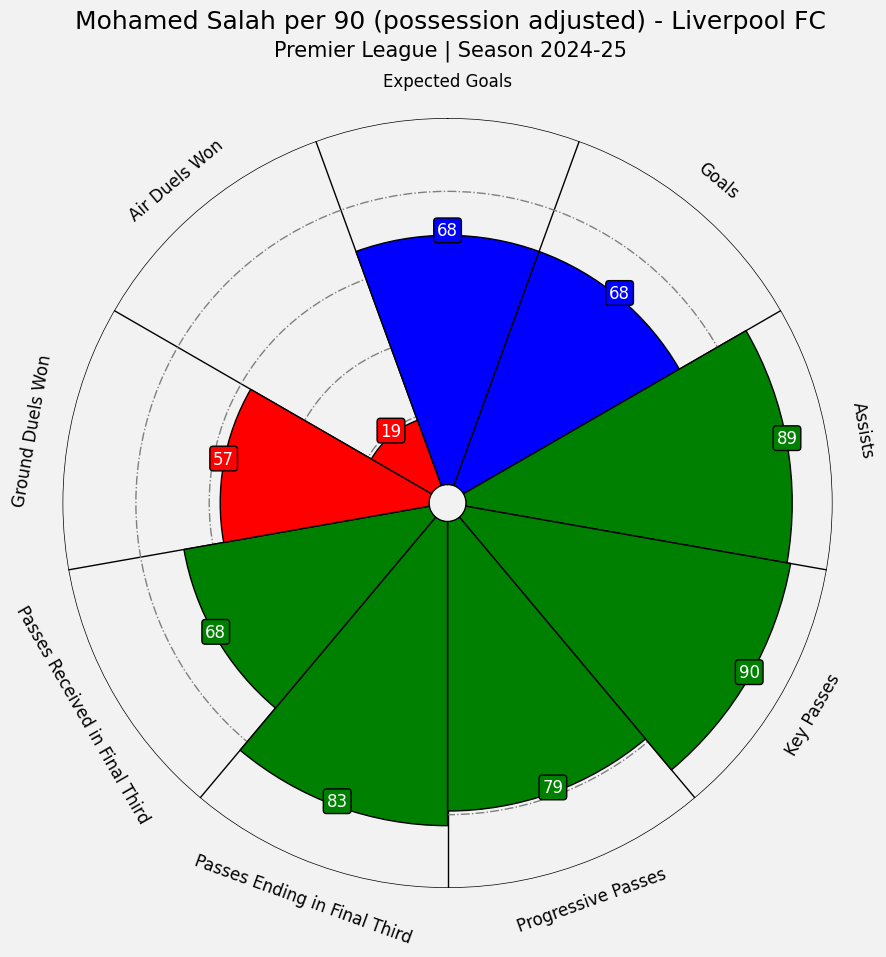

In [15]:
salah_adjusted = summary_adjusted.loc[summary_adjusted["player"] == "Enzo Fernández"]
salah_adjusted = salah_adjusted[['total_xg_adjusted_per90', "goals_adjusted_per90", "assists_adjusted_per90", 
                                  "key_passes_adjusted_per90", "progressive_passes_adjusted_per90", 
                                  "final_third_passes_adjusted_per90", "final_third_receptions_adjusted_per90", 
                                  "ground_duels_won_adjusted_per90", "air_duels_won_adjusted_per90"]]
adjusted_columns = salah_adjusted.columns[:]
values = [round(salah_adjusted[column].iloc[0], 2) for column in adjusted_columns]
percentiles = [int(stats.percentileofscore(summary_adjusted[column], salah_adjusted[column].iloc[0])) for column in adjusted_columns]
names = ["Expected Goals", "Goals", "Assists", "Key Passes", "Progressive Passes", 
         "Passes Ending in Final Third", "Passes Received in Final Third", "Ground Duels Won", "Air Duels Won"]

baker = PyPizza(
    params=names,
    straight_line_color="#000000",
    straight_line_lw=1,
    last_circle_lw=1,
    other_circle_lw=1,
    other_circle_ls="-."
)

fig, ax = baker.make_pizza(
    percentiles,
    figsize=(10, 10),
    param_location=110,
    slice_colors=slice_colors,
    value_colors=text_colors,
    value_bck_colors=slice_colors,
    kwargs_slices=dict(facecolor="cornflowerblue", edgecolor="#000000", zorder=2, linewidth=1),
    kwargs_params=dict(color="#000000", fontsize=12, va="center"),
    kwargs_values=dict(
        color="#000000", fontsize=12, zorder=3,
        bbox=dict(edgecolor="#000000", facecolor="cornflowerblue", boxstyle="round,pad=0.2", lw=1)
    )
)

fig.text(0.515, 0.97, "Mohamed Salah per 90 (possession adjusted) - Liverpool FC", size=18, ha="center", color="#000000")
fig.text(0.515, 0.942, "Premier League | Season 2024-25", size=15, ha="center", color="#000000")

plt.show()